In [65]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import seaborn as sns
from wordcloud import WordCloud
from itertools import islice
from collections import Counter


pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

csv_path = Path("netflix_titles.csv")
df = pd.read_csv(csv_path)
df.head(5)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [10]:
print("Rows, Columns:", df.shape)
print("\nColumns and dtypes:")
print(df.dtypes)
print("\nMissing values per column:")
print(df.isnull().sum().sort_values(ascending=False))


Rows, Columns: (7787, 12)

Columns and dtypes:
show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object

Missing values per column:
director        2389
cast             718
country          507
date_added        10
rating             7
title              0
show_id            0
type               0
release_year       0
duration           0
listed_in          0
description        0
dtype: int64


In [29]:

# Parse duration (extract integer minutes/seasons where possible)
def parse_duration(x):
    if pd.isna(x):
        return None
    s = str(x).strip()
    m = re.search(r'(\d+)', s)
    return int(m.group(1)) if m else None

df['duration_int'] = df['duration'].apply(parse_duration)

# Split listed_in (genres) into a cleaned list
def split_genres(s):
    if pd.isna(s):
        return []
    return [g.strip() for g in s.split(',')]

df['genres_list'] = df['listed_in'].apply(split_genres)

# Quick look
df[['title','type','release_year','duration','duration_int','listed_in']].head(8)


,title,type,release_year,duration,duration_int,listed_in
0,3%,TV Show,2020,4 Seasons,4,"International TV Shows, TV Dramas, TV Sci-Fi &..."
1,7:19,Movie,2016,93 min,93,"Dramas, International Movies"
2,23:59,Movie,2011,78 min,78,"Horror Movies, International Movies"
3,9,Movie,2009,80 min,80,"Action & Adventure, Independent Movies, Sci-Fi..."
4,21,Movie,2008,123 min,123,Dramas
5,46,TV Show,2016,1 Season,1,"International TV Shows, TV Dramas, TV Mysteries"
6,122,Movie,2019,95 min,95,"Horror Movies, International Movies"
7,187,Movie,1997,119 min,119,Dramas


In [30]:

# Top categories for a few columns
def top_counts(col, n=10):
    return df[col].value_counts(dropna=False).head(n)

top_type = top_counts('type', 10)
top_countries = top_counts('country', 15)
top_ratings = top_counts('rating', 15)

print("Top types:\n", top_type, "\n")
print("Top production countries (note: multiple countries may be combined in one string):\n", top_countries, "\n")
print("Top ratings:\n", top_ratings, "\n")


Top types:
 type
Movie      5377
TV Show    2410
Name: count, dtype: int64 

Top production countries (note: multiple countries may be combined in one string):
 country
United States     2555
India              923
NaN                507
United Kingdom     397
Japan              226
South Korea        183
Canada             177
Spain              134
France             115
Egypt              101
Mexico             100
Turkey             100
Australia           83
Taiwan              78
Brazil              72
Name: count, dtype: int64 

Top ratings:
 rating
TV-MA       2863
TV-14       1931
TV-PG        806
R            665
PG-13        386
TV-Y         280
TV-Y7        271
PG           247
TV-G         194
NR            84
G             39
NaN            7
TV-Y7-FV       6
UR             5
NC-17          3
Name: count, dtype: int64 



In [68]:
# Drop the few rows with missing 'date_added' and 'rating'
# Since the number is small (less than 0.2% of data), dropping them is a safe option.
df.dropna(subset=['date_added', 'rating'], inplace=True)

# Convert 'date_added' to datetime objects
# Use format='mixed' to handle potential variations in date formats
df['date_added'] = pd.to_datetime(df['date_added'], format='mixed', dayfirst=False)

# Create new features for year and month added
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month

In [37]:

# Explode genres list and count most common genres
genres_exploded = df.explode('genres_list')
top_genres = genres_exploded['genres_list'].value_counts().head(20)
top_genres


genres_list
International Movies        2437
Dramas                      2105
Comedies                    1471
International TV Shows      1197
Documentaries                786
Action & Adventure           721
TV Dramas                    703
Independent Movies           673
Children & Family Movies     532
Romantic Movies              531
TV Comedies                  517
Thrillers                    491
Crime TV Shows               426
Kids' TV                     411
Docuseries                   352
Romantic TV Shows            333
Stand-Up Comedy              329
Music & Musicals             321
Horror Movies                312
British TV Shows             231
Name: count, dtype: int64

In [38]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,duration_int,genres_list,year_added,month_added
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,4,"[International TV Shows, TV Dramas, TV Sci-Fi ...",2020,8
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,93,"[Dramas, International Movies]",2016,12
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",78,"[Horror Movies, International Movies]",2018,12
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",80,"[Action & Adventure, Independent Movies, Sci-F...",2017,11
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,123,[Dramas],2020,1


<Figure size 1400x800 with 0 Axes>

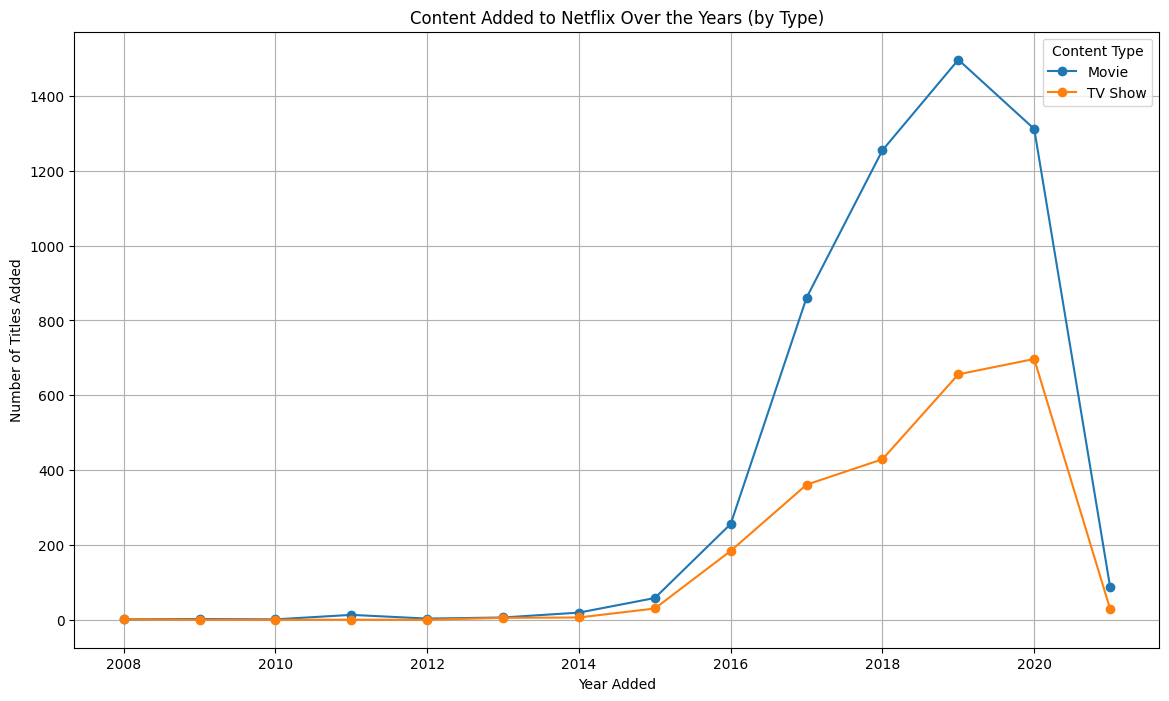

In [40]:

# Group data by year and content type
content_over_time = df.groupby(['year_added', 'type']).size().unstack().fillna(0)

plt.figure(figsize=(14, 8))
content_over_time.plot(kind='line', marker='o', figsize=(14, 8))
plt.title('Content Added to Netflix Over the Years (by Type)')
plt.xlabel('Year Added')
plt.ylabel('Number of Titles Added')
plt.legend(title='Content Type')
plt.grid(True)
plt.show()

**Insight:** By separating movies and TV shows, we can see that while both grew significantly, the addition of movies accelerated much more dramatically, peaking in 2019. The growth in TV shows has been more steady. There appears to be a slight slowdown in content additions in 2020 and 2021, which could be due to the COVID-19 pandemic affecting productions or the dataset being incomplete for the latest year.

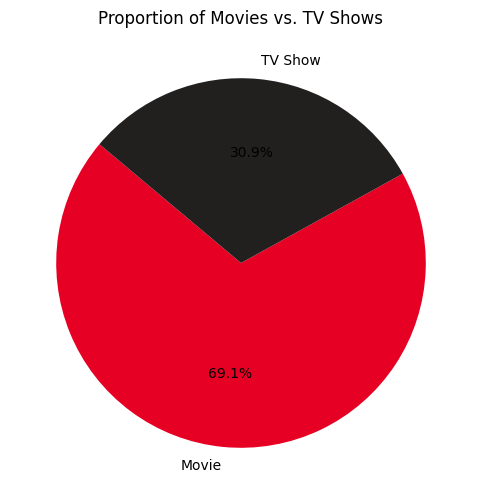

In [79]:
plt.figure(figsize=(8, 6))
type_counts = df['type'].value_counts()
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140, colors=['#e60023', '#221f1f'])
plt.title('Proportion of Movies vs. TV Shows')
plt.ylabel('')
plt.show()

**Insight:** The Netflix library is dominated by Movies, which make up roughly 70% of the content in this dataset.

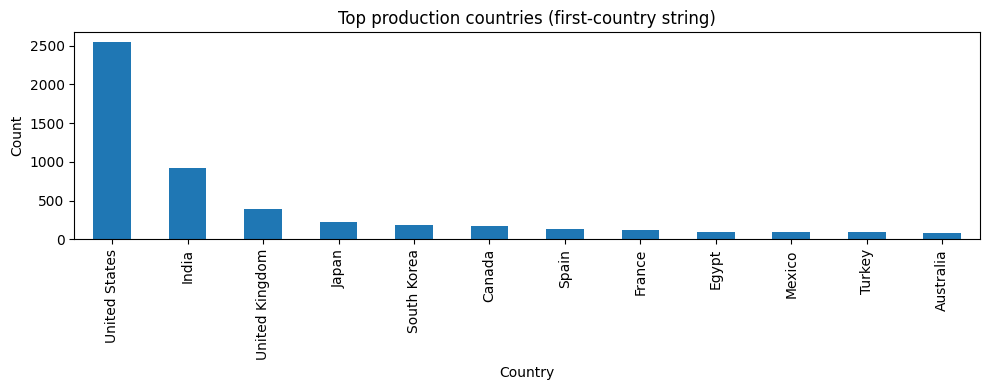

In [42]:

# Plot: top 12 production countries (naive counting)
plt.figure(figsize=(10,4))
top_countries = df['country'].dropna().value_counts().head(12)
top_countries.plot(kind='bar')
plt.title('Top production countries (first-country string)')
plt.xlabel('Country')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

**Insight:** The United States is by far the largest producer of content available on Netflix. However, India is a very strong second, which explains why so many of the top actors were from India. The UK, Japan, and South Korea also represent major content markets for the platform, emphasizing its global nature.

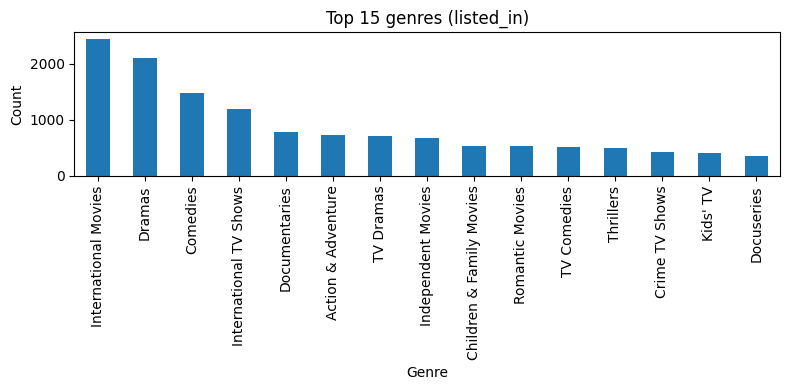

In [43]:
# Plot: top 15 genres
plt.figure(figsize=(8,4))
top_genres = df.explode('genres_list')['genres_list'].value_counts().head(15)
top_genres.plot(kind='bar')
plt.title('Top 15 genres (listed_in)')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

**Insight:** "International Movies" is the most common genre tag, highlighting Netflix's global content strategy. This is followed by Dramas, Comedies, and Action & Adventure.

In [48]:
# Separate movies and TV shows
movies_df = df[df['type'] == 'Movie'].copy()
tv_shows_df = df[df['type'] == 'TV Show'].copy()

# Clean and convert duration for movies
movies_df['duration_min'] = movies_df['duration'].str.replace(' min', '').astype(int)

# Clean and convert duration for TV shows
tv_shows_df['seasons'] = tv_shows_df['duration'].str.replace(' Seasons', '').str.replace(' Season', '').astype(int)

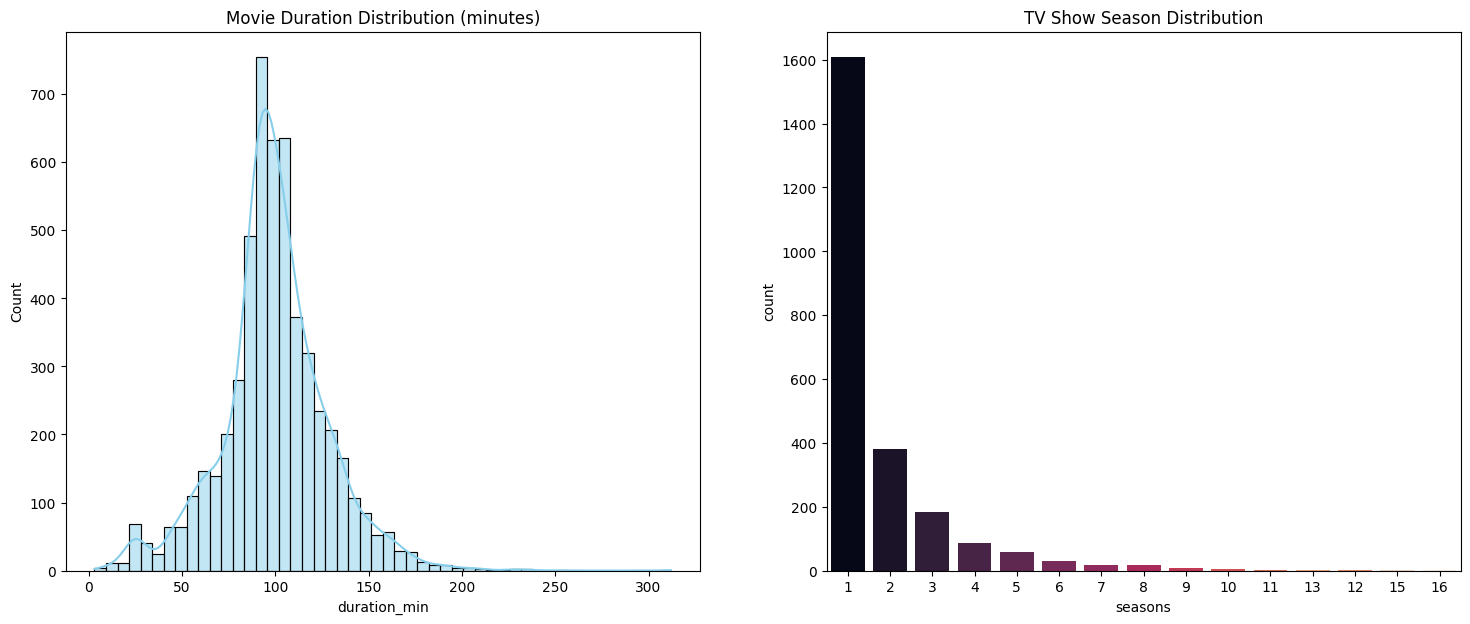

In [49]:
# Plot the distributions
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Movie Duration Distribution
sns.histplot(ax=axes[0], data=movies_df, x='duration_min', bins=50, kde=True, color='skyblue').set_title('Movie Duration Distribution (minutes)')

# TV Show Season Distribution
sns.countplot(ax=axes[1], x='seasons', data=tv_shows_df, palette='rocket', order=tv_shows_df['seasons'].value_counts().index, hue='seasons', legend=False).set_title('TV Show Season Distribution')

plt.show()

**Insight:**
- The majority of movies on Netflix are between 80 and 120 minutes long, which is standard for feature films.
- The vast majority of TV shows on Netflix are short-lived, with most having only 1 season. This could reflect a strategy of producing many pilots and only renewing the most successful ones, or a focus on limited series.

In [15]:

# Cross-tab: rating by type
ct = pd.crosstab(df['rating'].fillna('Missing'), df['type'].fillna('Missing'))
ct_sorted = ct.sum(axis=1).sort_values(ascending=False)
ct.loc[ct_sorted.index].head(15)


type,Movie,TV Show
rating,,
TV-MA,1845,1018
TV-14,1272,659
TV-PG,505,301
R,663,2
PG-13,386,0
TV-Y,117,163
TV-Y7,95,176
PG,247,0
TV-G,111,83


**Insight:** A large portion of Netflix's content is aimed at mature audiences, with `TV-MA` (Mature Audience) and `TV-14` (Parents Strongly Cautioned) being the two most common ratings. This suggests a focus on adult viewers over content for children (`TV-G`, `TV-Y`).

In [17]:

# Top directors and top cast members (if columns exist)
if 'director' in df.columns:
    top_directors = df['director'].dropna().value_counts().head(15)
    print("Top directors:\n", top_directors, "\n")

if 'cast' in df.columns:
    # split cast by comma and explode
    cast_series = df['cast'].dropna().str.split(',').explode().str.strip()
    top_cast = cast_series.value_counts().head(20)
    print("Top cast members (most frequent appearances):\n", top_cast, "\n")


Top directors:
 director
Raúl Campos, Jan Suter    18
Marcus Raboy              16
Jay Karas                 14
Cathy Garcia-Molina       13
Jay Chapman               12
Martin Scorsese           12
Youssef Chahine           12
Steven Spielberg          10
David Dhawan               9
Shannon Hartman            8
Ryan Polito                8
Johnnie To                 8
Quentin Tarantino          8
Robert Rodriguez           8
Kunle Afolayan             8
Name: count, dtype: int64 

Top cast members (most frequent appearances):
 cast
Anupam Kher            42
Shah Rukh Khan         35
Naseeruddin Shah       30
Om Puri                30
Takahiro Sakurai       29
Akshay Kumar           29
Yuki Kaji              27
Boman Irani            27
Paresh Rawal           27
Amitabh Bachchan       27
Kareena Kapoor         25
Andrea Libman          24
John Cleese            24
Vincent Tong           24
Tara Strong            22
Ashleigh Ball          22
Nawazuddin Siddiqui    21
Ajay Devgn        

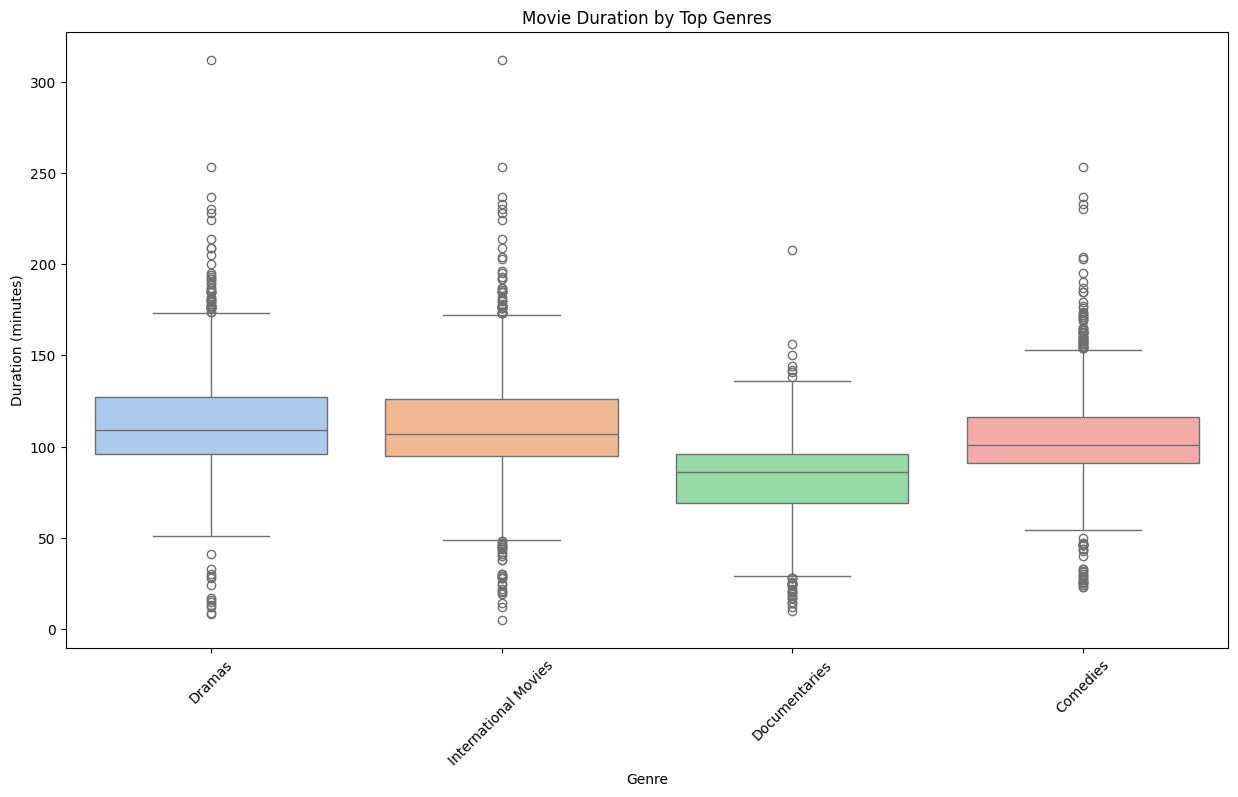

In [52]:
# Analyze movie duration across different top genres
genres = df.assign(genre= df['listed_in'].str.split(', ')).explode('genre')
top_genres = genres['genre'].value_counts().index[:5]
genres_movies = genres[(genres['type'] == 'Movie') & (genres['genre'].isin(top_genres))].copy()
genres_movies['duration_min'] = genres_movies['duration'].str.replace(' min', '').astype(int)

plt.figure(figsize=(15, 8))
sns.boxplot(data=genres_movies, x='genre', y='duration_min', palette='pastel', hue='genre', legend=False)
plt.title('Movie Duration by Top Genres')
plt.xlabel('Genre')
plt.ylabel('Duration (minutes)')
plt.xticks(rotation=45)
plt.show()

**Insight:** While the median duration for most top genres is similar (around 90-100 minutes), we can see some interesting variations. For example, Dramas tend to have a wider range of durations, with many longer films. International Movies also show a broad distribution, reflecting diverse filmmaking styles from around the world.

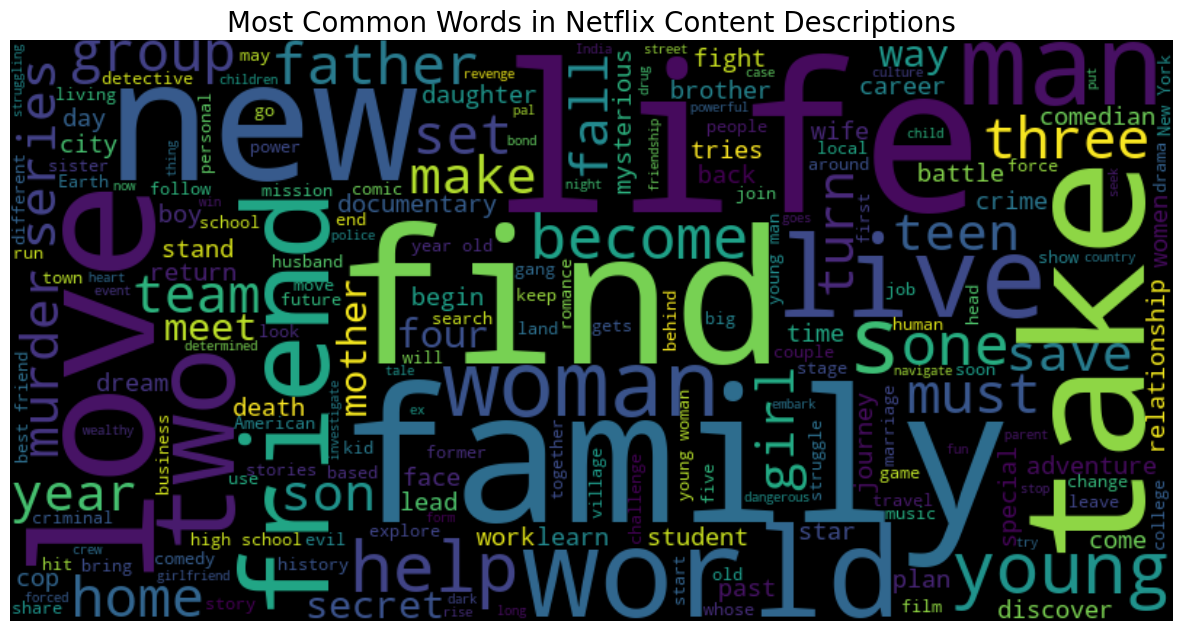

In [56]:
# Combine all descriptions into a single string
text = ' '.join(df['description'])

# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

# Display the generated image
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Netflix Content Descriptions', fontsize=20)
plt.show()

**Insight:** The word cloud highlights common themes and subjects. Words like "life," "family," "love," "young," "friends," and "world" are prominent, suggesting that much of the content revolves around human relationships and personal journeys. Action-oriented words like "find," "secret," and "new" also appear frequently.

# Submission Q's

# How has the distribution of content ratings changed over time?

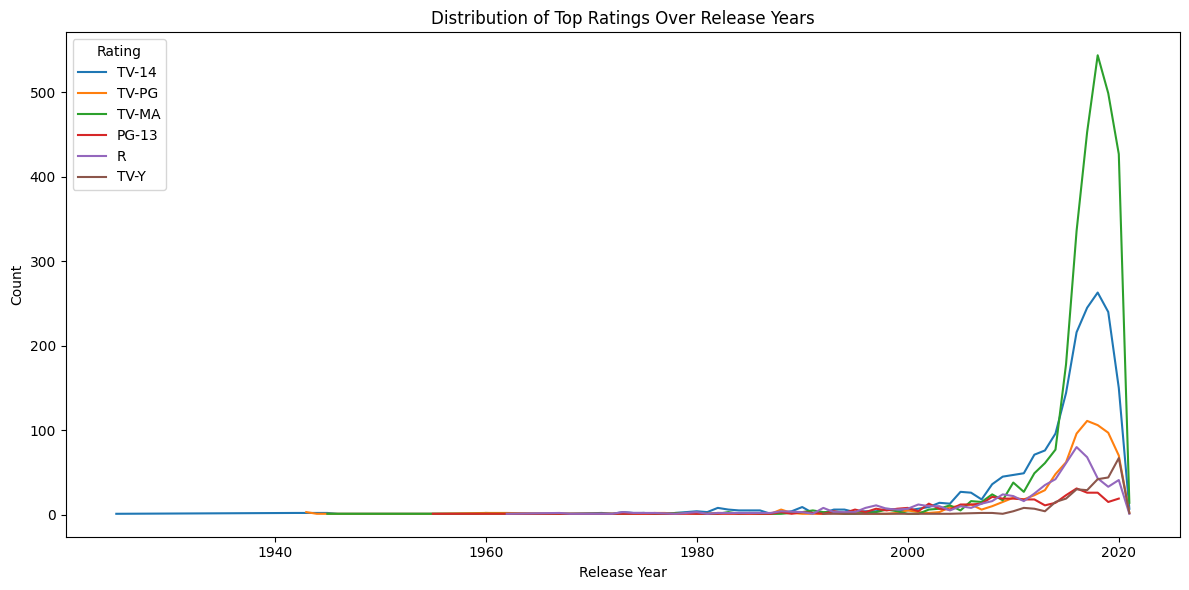

In [57]:
# Distribution of content ratings over release years
ratings_by_year = df.groupby(['release_year','rating']).size().reset_index(name='count')

plt.figure(figsize=(12,6))
top_ratings = df['rating'].value_counts().head(6).index
ratings_filtered = ratings_by_year[ratings_by_year['rating'].isin(top_ratings)]
sns.lineplot(data=ratings_filtered, x='release_year', y='count', hue='rating')
plt.title("Distribution of Top Ratings Over Release Years")
plt.xlabel("Release Year")
plt.ylabel("Count")
plt.legend(title="Rating")
plt.tight_layout()
plt.show()

**Insight:**

- **Ratings:** TV-MA and TV-14 dominate recent years, while older titles show more PG/PG-13.  

# Is there a relationship between content age and its type (Movie vs. TV Show)?

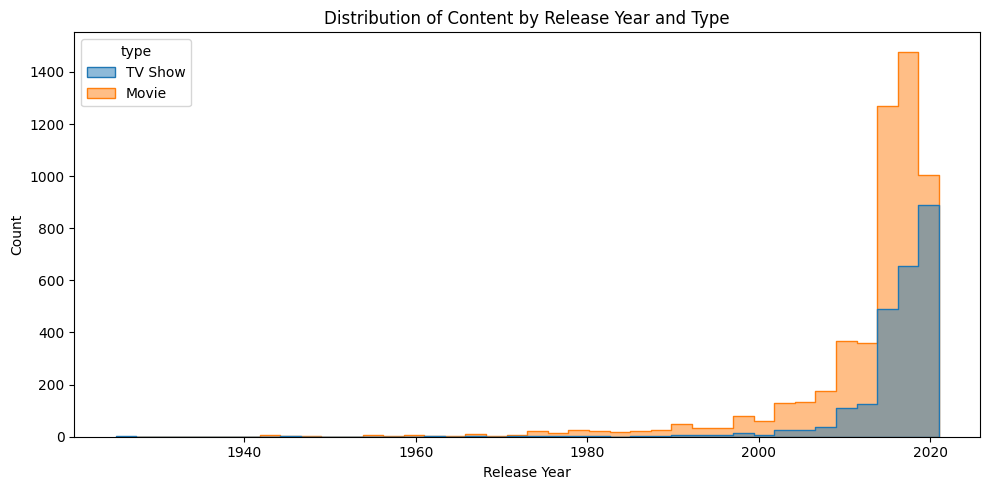

In [58]:

# Relationship between content age (release_year) and type
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='release_year', hue='type', element='step', bins=40, alpha=0.5)
plt.title("Distribution of Content by Release Year and Type")
plt.xlabel("Release Year")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

**Insight:**

- **Type:** Movies span a wide time range; TV shows are concentrated after 2000. 

 # Can we identify any trends in content production based on the release year vs. the year added to Netflix?

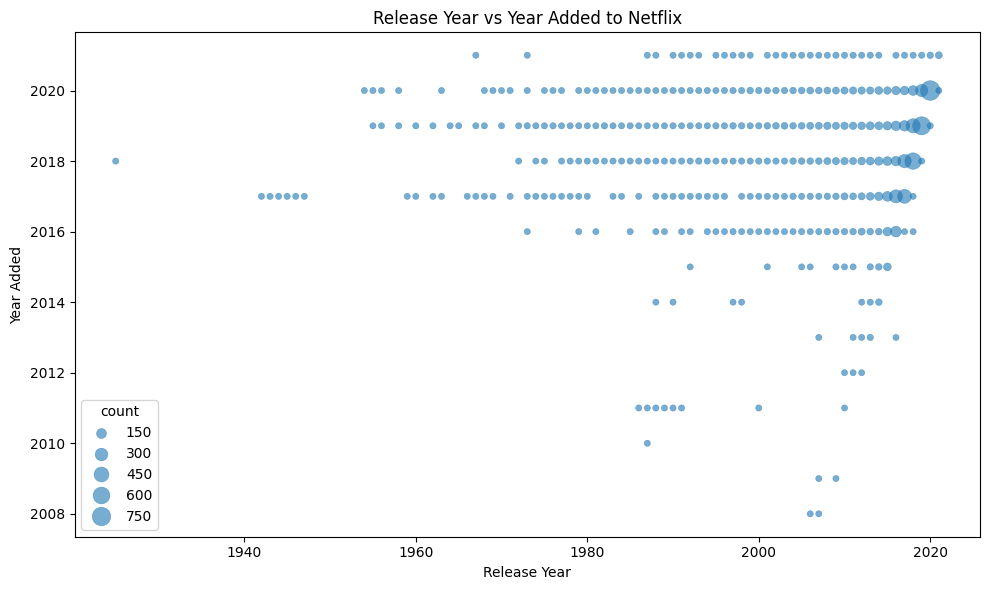

In [76]:
year_trends = df.groupby(['release_year','year_added']).size().reset_index(name='count') 
plt.figure(figsize=(10,6)) 
sns.scatterplot(data=year_trends, x='release_year', y='year_added', size='count', sizes=(20,200), alpha=0.6, edgecolor=None) 
plt.title("Release Year vs Year Added to Netflix") 
plt.xlabel("Release Year") 
plt.ylabel("Year Added") 
plt.tight_layout() 
plt.show()

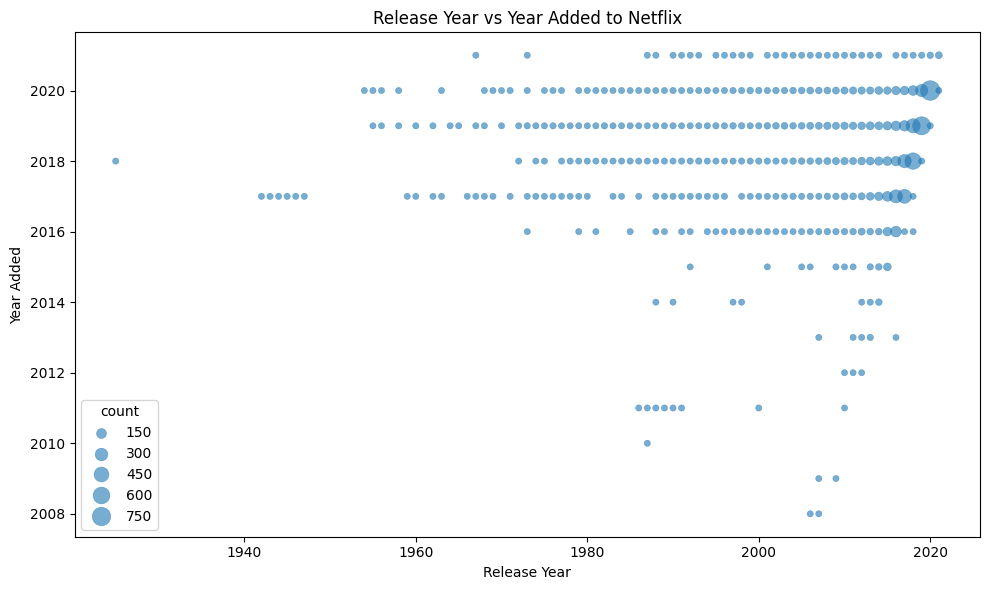

In [71]:

# Trends in release year vs. year added to Netflix
year_trends = df.groupby(['release_year','year_added']).size().reset_index(name='count')
year_trends = df.groupby(['release_year','year_added']).size().reset_index(name='count') 
plt.figure(figsize=(10,6)) 
sns.scatterplot(data=year_trends, x='release_year', y='year_added', size='count', sizes=(20,200), alpha=0.6, edgecolor=None) 
plt.title("Release Year vs Year Added to Netflix") 
plt.xlabel("Release Year") 
plt.ylabel("Year Added") 
plt.tight_layout() 
plt.show()

**Insight:**
- **Trends:** More recent releases are quickly added to Netflix, with a surge post-2015.

# What are the most common word pairs or phrases in content descriptions?

In [77]:

# Most common word pairs in descriptions
def extract_bigrams(text):
    words = re.findall(r'\b\w+\b', str(text).lower())
    return zip(words, islice(words,1,None))

all_bigrams = Counter()
for desc in df['description'].dropna():
    all_bigrams.update(extract_bigrams(desc))

top_bigrams = all_bigrams.most_common(20)
bigrams_df = pd.DataFrame(top_bigrams, columns=['bigram','count'])
bigrams_df['bigram'] = bigrams_df['bigram'].apply(lambda x: ' '.join(x))

bigrams_df


,bigram,count
0,in a,630
1,in this,613
2,in the,602
3,of the,588
4,of a,495
5,with a,410
6,on a,390
7,a young,369
8,when a,350
9,to the,339


**Insight:**
- **Descriptions:** Frequent phrases include "in a", "in this", "in the".

#  Who are the top directors on Netflix?

In [78]:
# Top directors by number of titles
top_directors = df['director'].dropna().str.split(',').explode().str.strip().value_counts().head(20)
top_directors_df = top_directors.reset_index().rename(columns={'index':'director','director':'count'})
top_directors_df


,count,count
0,Jan Suter,21
1,Raúl Campos,19
2,Marcus Raboy,16
3,Jay Karas,15
4,Cathy Garcia-Molina,13
5,Youssef Chahine,12
6,Martin Scorsese,12
7,Jay Chapman,12
8,Steven Spielberg,10
9,David Dhawan,9


**Insight:**
- **Descriptions:** Frequent phrases include "young woman", "high school", "best friends".

**Insight:**
- **Top Directors are:** Jan Suter, Raúl Campos, and Marcus Raboy lead in number of Netflix titles.  

**Insight:**